In [1]:
# why use SVK when you could just use y = mx + b

import numpy as np
from scipy import optimize
from aberrations import make_vibe_params, make_1D_vibe_data, make_noisy_data, measurement_noise, f_1
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update, noise_filter
from matplotlib import pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
from aberrations import time_id, f_sampling, f_1, times
W = 9
N = 1
N_vib_app = 1
steps = int(f_sampling * time_id)
times = np.arange(0, time_id, 1 / f_sampling)

In [3]:
# set up state training datam
params = make_vibe_params(N=N_vib_app)
truth = make_1D_vibe_data(vib_params=params)
measurements = make_noisy_data(truth, noise=0.06)

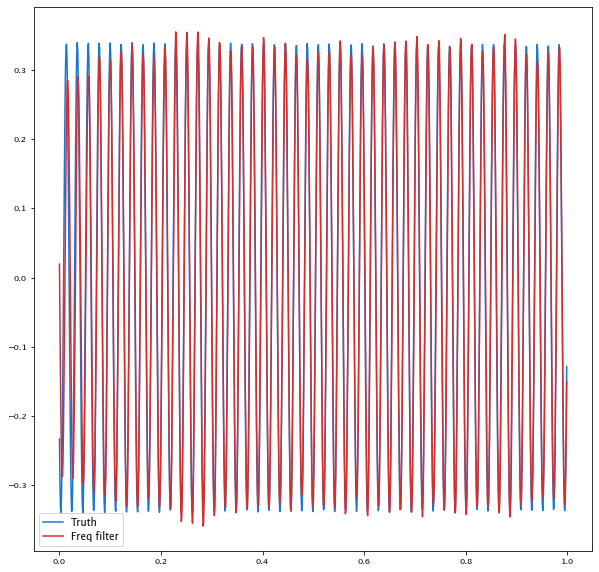

In [4]:
# first, let's run the Kalman filter for a second normally
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=N))
states_freq = np.zeros((steps, state.size))
for k in range(steps):
    state, P = update(H, P, R, state, measurements[k])
    states_freq[k] = state
    state, P = predict(A, P, Q, state)
    
pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()

plt.figure(figsize=(10,10))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_freq, label='Freq filter')
plt.legend()

In [5]:
def make_state_transition(states):
    A = np.zeros((STATE_SIZE, STATE_SIZE))
    Q = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(N):
        states_i = states[:,2*i:2*i+1].flatten()
        cost_i = lambda a: sum([(states_i[k+1] - a[0] * states_i[k] - a[1] * states_i[k-1])**2 for k in range(1, W)])
        par0 = [0.9, -0.999]
        result = optimize.minimize(cost_i, par0)
        print(result.x)
        A[2*i][2*i], A[2*i][2*i+1] = result.x
        A[2*i+1][2*i] = 1
        Q[2*i][2*i] = result.fun
        
    return A, Q

In [6]:
# evolve states based on this A.

print("Target autoregressive coefficients:")
k = params[2]
w0 = 2 * np.pi * params[1]
print(2 *  np.exp(-k * w0 / f_sampling) * np.cos(w0 * np.sqrt(1 - k**2) / f_sampling))
print(-np.exp(-2 * k * w0 / f_sampling))
# can only do this with N = 1, otherwise matching by eye gets tough.
# could try and plot both over time, but could also not

print("Frequency-identified autoregressive coefficients:")
print(A[0][0])
print(A[0][1])

k = W + 1
state = states_freq[k]
states_lin = np.zeros((steps, state.size))
states_lin[:k] = states_freq[:k]
STATE_SIZE = 2*N
last_refresh = 0
while k < steps:
    # Make the A matrix for a transition from state k to state k + 1. Assumed k > W + 1.
    # threshold is arbitrary
    # np.any([P[2*i][2*i] > 10 * Q[2*i][2*i] for i in range(N)]) and k - last_refresh > W and np.sum(np.diag(P)) > 10 * np.sum(np.diag(Q))
    if np.sum(np.diag(P)) > 0.01 * N and k - last_refresh > W:
        print("Refreshing A, Q at timestep", k)
        last_refresh = k
        states_to_regress = deepcopy(states_lin[k-W-1:k])
        A, Q = make_state_transition(states_to_regress)
    elif k - last_refresh == W + 1:
        assert(np.all(np.diag(P) > 0))
        print("State covariance estimate: ", np.sum(np.diag(P)))
        print("Autoregressive coefficients: ", A[0][0], A[0][1])
    state, P = update(H, P, R, state, measurements[k])
    states_lin[k] = state
    state, P = predict(A, P, Q, state)
    k += 1
    
pos_lin = np.array([H.dot(state) for state in states_lin]).flatten()

Target autoregressive coefficients:
[1.91571964]
[-0.99998272]
Frequency-identified autoregressive coefficients:
1.9169173990339576
-0.9998683651746727
State covariance estimate:  0.007640761660238034
Autoregressive coefficients:  1.9169173990339576 -0.9998683651746727


(-0.33929525802412935, 0.33929525802412935)

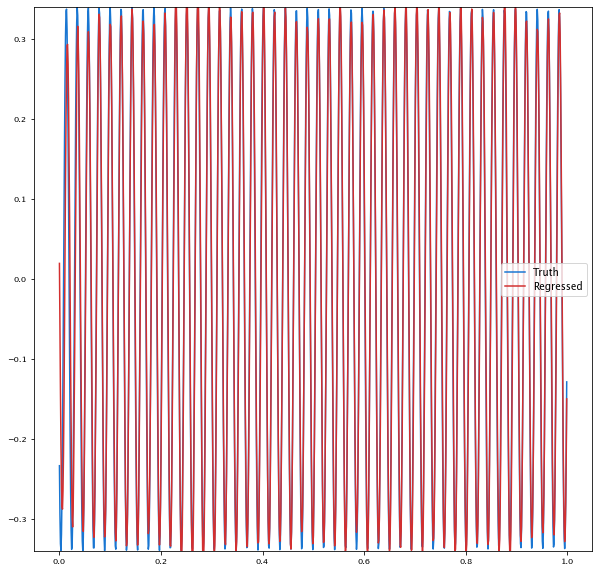

In [7]:
plt.figure(figsize=(10,10))
lim = np.max(np.abs(truth))
plt.plot(times, truth, label='Truth')
plt.plot(times, pos_lin, label='Regressed')
plt.legend()
plt.ylim(-lim, lim)

Text(0.5, 1.0, 'Residuals of frequency fit and linear regression')

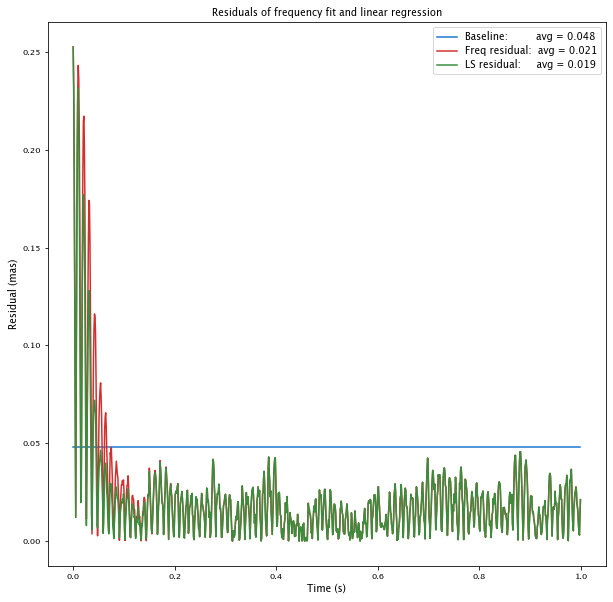

In [8]:
plt.figure(figsize=(10,10))
baseline = np.round(np.mean(np.abs(measurements - truth)), 3)
plt.plot(times, [baseline] * times.size, label='Baseline:         avg = ' + str(baseline))
res_lin = np.abs(pos_lin - truth)
res_freq = np.abs(pos_freq - truth)
plt.plot(times, res_freq, label='Freq residual:  avg = ' 
         + str(np.round(np.mean(res_freq[W+1:]), 3)))
plt.plot(times, res_lin, label='LS residual:     avg = ' 
         + str(np.round(np.mean(res_lin[W+1:]), 3)))
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Residual (mas)")
plt.title("Residuals of frequency fit and linear regression")